In [10]:
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
import requests
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import hvplot.pandas
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#Import SKLearn Library and Classes
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [19]:
#set path to Features CSV and read in CSV
tsla_df = pd.read_pickle('Resources/tsla_features_df.pickle')
tsla_df.tail()

,tsla Close,tsla Volume,Call Volume,Put Volume,Total Option Volume,Percent of Puts,Put signals,Percent of calls,Call signals,bollinger_mid_band,...,rvol SD,rvol signal,Option rVol,Option rVol SD,Option rVol signal,daily returns,sent_by_sentence_score,sentiment neg,sentiment pos,sentiment score
2019-12-23,419.1800,12734119,79490.0,97992.0,177482.0,0.169595,False,0.447876,False,356.874050,...,1.355624,1.0,0.686526,1.355624,1.0,0.033609,0.0000,0,0,0
2019-12-24,425.1800,7833308,176661.0,120624.0,297285.0,0.481798,False,0.594248,False,361.318005,...,1.348138,0.0,1.122894,1.348138,0.0,0.014314,0.0000,0,0,0
2019-12-26,430.8202,10131052,115778.0,80880.0,196658.0,0.106826,False,0.588728,False,366.412515,...,1.367534,0.0,0.734805,1.367534,0.0,0.013265,-0.6249,-1,0,-1
2019-12-27,430.2300,9209880,144265.0,97534.0,241799.0,0.081509,False,0.596632,False,371.371515,...,1.383196,0.0,0.894463,1.383196,0.0,-0.001370,0.0000,0,0,0
2019-12-30,414.6200,12082466,73880.0,54782.0,128662.0,0.066566,False,0.574218,False,375.600515,...,1.411808,0.0,0.480957,1.411808,0.0,-0.036283,0.0000,0,0,0


In [20]:
#Create new trading signals Df, 
trading_signals_df = pd.DataFrame()

In [21]:
#create features only dataframe by shifting feature signal, select features as x_var_list (for selling OTM puts, bollinger = bollinger short)

x_var_list = ['bollinger_short', 'rvol signal', 'Option rVol signal', 'sentiment neg']

trading_signals_df[x_var_list] = tsla_df[x_var_list].shift(1)

trading_signals_df = trading_signals_df.set_index(pd.to_datetime(tsla_df.index, infer_datetime_format=True))
trading_signals_df.head()

,bollinger_short,rvol signal,Option rVol signal,sentiment neg
2019-08-05,NaN,NaN,NaN,NaN
2019-08-06,0.0,0.0,0.0,0.0
2019-08-07,0.0,0.0,0.0,0.0
2019-08-08,0.0,0.0,0.0,0.0
2019-08-09,0.0,0.0,0.0,0.0


In [22]:
#add dependent variable for targeting a positive return, shift forward looking window by user defined amount
shift = 7
threshold = 0
trading_signals_df['Positive Return'] = np.where(tsla_df['daily returns'].shift(-shift)> threshold, 1, 0)

In [23]:
#drop Na and reduce df by shift amount
trading_signals_df = trading_signals_df.dropna()
trading_signals_df = trading_signals_df[:-shift]
trading_signals_df.tail()

,bollinger_short,rvol signal,Option rVol signal,sentiment neg,Positive Return
2019-12-12,-1.0,1.0,1.0,0.0,1
2019-12-13,-1.0,1.0,1.0,0.0,1
2019-12-16,-1.0,0.0,0.0,-1.0,1
2019-12-17,-1.0,1.0,1.0,-1.0,0
2019-12-18,-1.0,0.0,0.0,0.0,0


In [24]:
# Manually splitting the data
split = int(0.7 * len(trading_signals_df))

X_train = trading_signals_df.iloc[: split, :-1]
X_test = trading_signals_df.iloc[split:, :-1]

y_train = trading_signals_df['Positive Return'][:split]
y_test = trading_signals_df['Positive Return'][split:]


In [25]:
#Train Random Forest Model
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

In [26]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["RF Predicted Value"] = predictions
Results['Forward Daily Returns'] = tsla_df['daily returns'].shift(-shift)
Results

,Positive Return,RF Predicted Value,Forward Daily Returns
2019-11-13,0,1,-0.061920
2019-11-14,1,1,0.009943
2019-11-15,0,1,-0.021918
2019-11-18,1,1,0.006445
2019-11-19,0,1,-0.003051
2019-11-20,1,1,0.014604
2019-11-21,1,1,0.003643
2019-11-22,0,1,-0.009194
2019-11-25,0,0,-0.007958
2019-11-26,1,1,0.016680


In [33]:
Results['RF Predicted Value'].to_pickle(r'C:\Users\Kiel\Desktop\FINTECH\UCB_fintech_homework\project_2 - local\Resources\TSLA_RF_signals_df.pickle')

<AxesSubplot:>

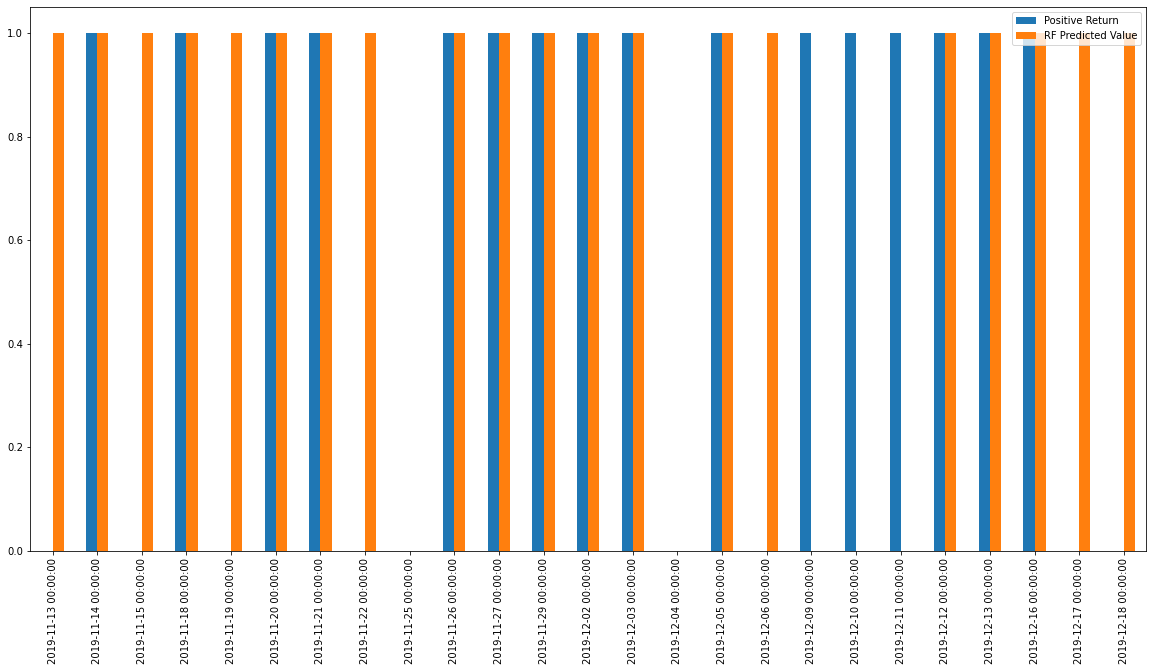

In [29]:
Results[['Positive Return', 'RF Predicted Value']].plot(figsize=(20,10), kind = 'bar')

<AxesSubplot:>

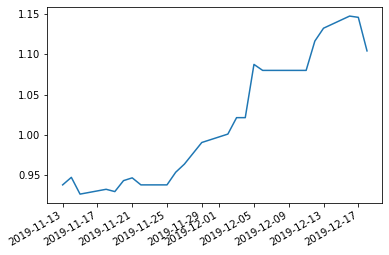

In [31]:
# Calculate cumulative return of model and plot the result
(1 + (Results['Forward Daily Returns'] * Results['RF Predicted Value'])).cumprod().plot()

<AxesSubplot:>

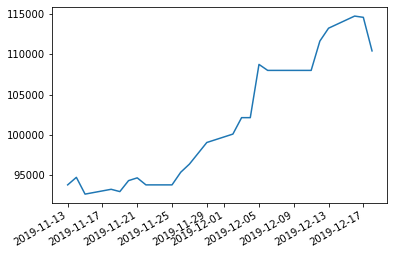

In [32]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (Results['Forward Daily Returns'] * Results['RF Predicted Value'])).cumprod()
cumulative_return_capital.plot()